In [3]:
import pandas as pd

data = pd.read_excel("/content/Horizontal_Format.xlsx")

data.head()


,TiD,items
0,1,"M,O,N,K,E,Y"
1,2,"D,O,N,K,E,Y"
2,3,"M,A,K,E"
3,4,"M,U,C,K,Y"
4,5,"C,O,O,K,I,E"


In [4]:
#  Data Preprocessing
# Convert the 'items' column to a list of sets, each representing a transaction

transactions = []
for item in data['items']:
    transaction_set = set(item.split(','))
    transactions.append(transaction_set)
# Display the first few transactions to confirm transformation
transactions[0:5]

[{'E', 'K', 'M', 'N', 'O', 'Y'},
 {'D', 'E', 'K', 'N', 'O', 'Y'},
 {'A', 'E', 'K', 'M'},
 {'C', 'K', 'M', 'U', 'Y'},
 {'C', 'E', 'I', 'K', 'O'}]

In [5]:
from collections import defaultdict
from itertools import combinations

# Step 2: Implement Candidate Generation and Support Calculation

def generate_candidates(itemsets, k):
    """
    Generate candidate itemsets of size k from the given itemsets.
    """
    candidates = set()
    itemsets_list = list(itemsets)

    one_item = 0 #bool

    if(len(itemsets_list[0]) == 1):
      one_item = 1

    for i in range(len(itemsets_list)):
        for j in range(i + 1, len(itemsets_list)):
            #to be able to compare its elements -> convert to list
            itemset1 = list(itemsets_list[i])
            itemset2 = list(itemsets_list[j])


            if one_item:
              #if it's one item union easly
              candidate = itemsets_list[i].union(itemsets_list[j])
              if len(candidate) == k:
                candidates.add(candidate)
            else:
              #else check if first k-1 items are equal then union
              for k in range(len(itemset1)-1):
                if itemset1[k] != itemset2[k]:
                  break
                else:
                  candidate = itemsets_list[i].union(itemsets_list[j])
                  if len(candidate) == k:
                      candidates.add(candidate)
    return candidates

In [6]:


def calculate_support(transactions, candidates):
    """
    Calculate the support of each candidate in the transaction dataset.
    Returns a dictionary with candidate itemsets as keys and support as values.
    """
    support_counts = {}
    for transaction in transactions:
        for candidate in candidates:
            if candidate.issubset(transaction):
              if candidate not in support_counts:
                  support_counts[candidate] = 0
              support_counts[candidate] += 1
    # Convert support counts to support persentage
    support = {}
    for itemset, count in support_counts.items():
        support[itemset] = count / len(transactions)
    return support

# Define a minimum support threshold
min_support = 0.6

# Step 3: Generate frequent itemsets iteratively

def apriori(transactions, min_support):
    """
    Generate all frequent itemsets using the Apriori algorithm.
    Returns a dictionary of frequent itemsets with their support values.
    """
    # Initialize variables
    k = 1
    frequent_itemsets = {}

    # Generate initial single-item candidates

    # single_items = set()
    # for transaction in transactions:
    #     for item in transaction:
    #         single_items.add(item)

    current_itemsets = set()
    for transaction in transactions:
        for item in transaction:
          current_itemsets.add(frozenset([item]))#to be able to put it as a key , and do operations on it like union and issubstet

    # Iteratively generate frequent itemsets of increasing size
    while current_itemsets:
        # Calculate support for current itemsets
        support = calculate_support(transactions, current_itemsets)

        # Filter itemsets by minimum support
        #current_frequent_itemsets = {}
        for itemset, support in support.items():
            if support >= min_support:
                frequent_itemsets[itemset] = support

        # Generate candidates for the next level
        current_itemsets = generate_candidates(frequent_itemsets.keys(), k + 1)

        # Increment k to generate the next level of itemsets
        k += 1

    return frequent_itemsets

# Run the Apriori algorithm on our dataset
frequent_itemsets = apriori(transactions, min_support)

# Display the frequent itemsets and their support values
frequent_itemsets


{frozenset({'E'}): 0.8,
 frozenset({'O'}): 0.6,
 frozenset({'M'}): 0.6,
 frozenset({'K'}): 1.0,
 frozenset({'Y'}): 0.6,
 frozenset({'K', 'Y'}): 0.6,
 frozenset({'E', 'K'}): 0.8,
 frozenset({'K', 'M'}): 0.6,
 frozenset({'K', 'O'}): 0.6,
 frozenset({'E', 'O'}): 0.6,
 frozenset({'E', 'K', 'O'}): 0.6}

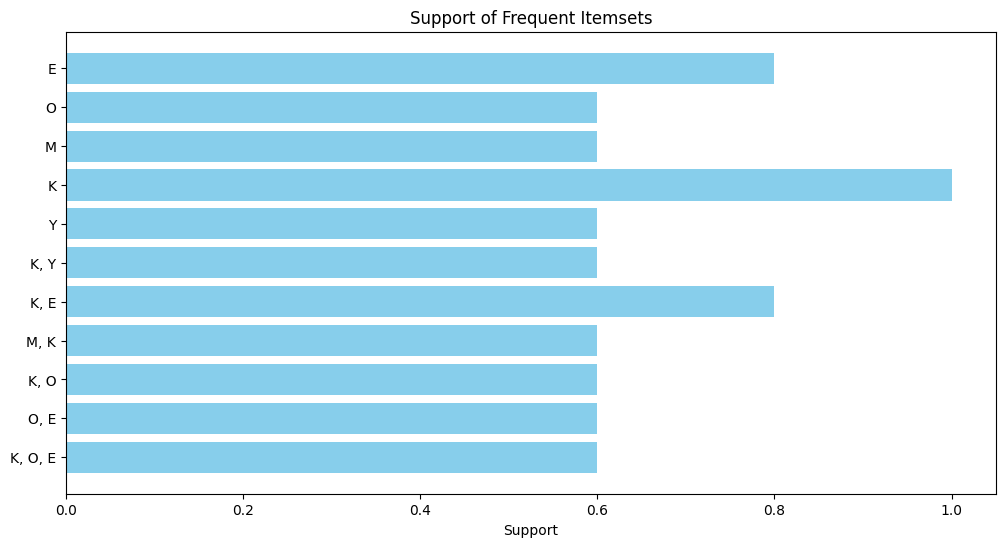

In [7]:
import matplotlib.pyplot as plt

# Convert the frequent itemsets dictionary to a DataFrame for easier plotting
frequent_itemsets_df = pd.DataFrame(list(frequent_itemsets.items()), columns=['Itemset', 'Support'])
frequent_itemsets_df['Itemset'] = frequent_itemsets_df['Itemset'].apply(lambda x: ', '.join(x))

# Plot a bar chart of frequent itemsets' support values
plt.figure(figsize=(12, 6))
plt.barh(frequent_itemsets_df['Itemset'], frequent_itemsets_df['Support'], color='skyblue')
plt.xlabel('Support')
plt.title('Support of Frequent Itemsets')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [37]:
from itertools import combinations

def generate_association_rules(frequent_itemsets, min_confidence,transactions):
    """
    Generate association rules from frequent itemsets that meet the minimum confidence threshold.
    Returns a list of rules with confidence and lift values.
    """
    rules = []
    num_transactions = len(transactions);
    # Iterate through each frequent itemset
    for itemset, itemset_support in frequent_itemsets.items():
      # Generate all non-empty subsets of the itemset
      for item in itemset:
        first = frozenset(itemset - {item})
        second = frozenset({item})

        # Calculate confidence
        if first in frequent_itemsets:
          #if condition because if it was 1-itemset ,then first will be nothing
          confidence = itemset_support / frequent_itemsets[first]

          # Only keep rules that meet the minimum confidence
          if confidence >= min_confidence:
              # Calculate lift
              lift = calc_lift(itemset_support,first,second,frequent_itemsets,transactions)
              # Store the rule with its metrics
              rules.append((first, second, confidence, lift))

    return rules
def calc_lift(itemset_support,first,second,frequent_itemsets,transactions):
  num_transactions = len(transactions);

  itemset_probability = (itemset_support/num_transactions)
  first_probability = (frequent_itemsets[first]/num_transactions)
  second_probability = (frequent_itemsets[second]/num_transactions)

  lift = itemset_probability / (first_probability * second_probability)
  return lift

# Define a minimum confidence threshold
min_confidence = 0.8

# Generate association rules
association_rules = generate_association_rules(frequent_itemsets, min_confidence,transactions)

# Display the generated rules
association_rules


[(frozenset({'Y'}), frozenset({'K'}), 1.0, 5.0),
 (frozenset({'E'}), frozenset({'K'}), 1.0, 5.0),
 (frozenset({'K'}), frozenset({'E'}), 0.8, 5.0),
 (frozenset({'M'}), frozenset({'K'}), 1.0, 5.0),
 (frozenset({'O'}), frozenset({'K'}), 1.0, 5.0),
 (frozenset({'O'}), frozenset({'E'}), 1.0, 6.25),
 (frozenset({'E', 'O'}), frozenset({'K'}), 1.0, 5.0),
 (frozenset({'K', 'O'}), frozenset({'E'}), 1.0, 6.25)]

In [41]:
# Print each association rule in a readable format
print("Association Rules:")
for first, second, confidence, lift in association_rules:
    print(f"Rule: {set(first)} -> {set(second)}")
    print(f"Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")


Association Rules:
Rule: {'Y'} -> {'K'}
Confidence: 1.00, Lift: 5.00

Rule: {'E'} -> {'K'}
Confidence: 1.00, Lift: 5.00

Rule: {'K'} -> {'E'}
Confidence: 0.80, Lift: 5.00

Rule: {'M'} -> {'K'}
Confidence: 1.00, Lift: 5.00

Rule: {'O'} -> {'K'}
Confidence: 1.00, Lift: 5.00

Rule: {'O'} -> {'E'}
Confidence: 1.00, Lift: 6.25

Rule: {'E', 'O'} -> {'K'}
Confidence: 1.00, Lift: 5.00

Rule: {'K', 'O'} -> {'E'}
Confidence: 1.00, Lift: 6.25



In [ ]:
# Test with different minimum support and confidence values
min_support_values = [0.2, 0.3, 0.4]
min_confidence_values = [0.6, 0.7, 0.8]

for support in min_support_values:
    for confidence in min_confidence_values:
        print(f"\nmin_support = {support} and min_confidence = {confidence}\n")

        # Generate frequent itemsets
        frequent_itemsets = apriori(transactions, support)

        # Generate association rules
        rules = generate_association_rules(frequent_itemsets, confidence)

        # Display the results
        print("Association Rules:")
        for first, second, confidence, lift in rules:
            print(f"Rule: {set(first)} -> {set(second)}")
            print(f"Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")



Testing with min_support = 0.2 and min_confidence = 0.6

Association Rules:
Rule: {'O'} -> {'Y'}
Confidence: 0.67, Lift: 1.11

Rule: {'Y'} -> {'O'}
Confidence: 0.67, Lift: 1.11

Rule: {'E'} -> {'O'}
Confidence: 0.75, Lift: 1.25

Rule: {'O'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'Y'} -> {'E'}
Confidence: 0.67, Lift: 0.83

Rule: {'M'} -> {'E'}
Confidence: 0.67, Lift: 0.83

Rule: {'K'} -> {'Y'}
Confidence: 0.60, Lift: 1.00

Rule: {'Y'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'N'} -> {'E'}
Confidence: 1.00, Lift: 1.25

Rule: {'N'} -> {'Y'}
Confidence: 1.00, Lift: 1.67

Rule: {'Y'} -> {'N'}
Confidence: 0.67, Lift: 1.67

Rule: {'M'} -> {'Y'}
Confidence: 0.67, Lift: 1.11

Rule: {'Y'} -> {'M'}
Confidence: 0.67, Lift: 1.11

Rule: {'O'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'O'}
Confidence: 0.60, Lift: 1.00

Rule: {'E'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule: {'K'} -> {'E'}
Confidence: 0.80, Lift: 1.00

Rule: {'N'} -> {'K'}
Confidence: 1.00, Lift: 1.00

Rule:

In [48]:
def apriori_levels(transactions, min_support):
    """
    Generate frequent itemsets organized by their level (L1, L2, ... LK).
    """
    frequent_itemsets_by_level = {}

    frequent_itemsets = apriori(transactions, min_support)

    for itemset, support in frequent_itemsets.items():

        if len(itemset) not in frequent_itemsets_by_level:
            frequent_itemsets_by_level[len(itemset)] = []

        frequent_itemsets_by_level[len(itemset)].append({itemset: support})

    return frequent_itemsets_by_level

# trying the function
min_support = 0.3
frequent_itemsets_by_level = apriori_levels(transactions, min_support)
frequent_itemsets_by_level


{1: [{frozenset({'E'}): 0.8},
  {frozenset({'O'}): 0.6},
  {frozenset({'M'}): 0.6},
  {frozenset({'K'}): 1.0},
  {frozenset({'N'}): 0.4},
  {frozenset({'Y'}): 0.6},
  {frozenset({'C'}): 0.4}],
 2: [{frozenset({'K', 'Y'}): 0.6},
  {frozenset({'E', 'N'}): 0.4},
  {frozenset({'E', 'Y'}): 0.4},
  {frozenset({'N', 'O'}): 0.4},
  {frozenset({'K', 'M'}): 0.6},
  {frozenset({'E', 'M'}): 0.4},
  {frozenset({'E', 'O'}): 0.6},
  {frozenset({'E', 'K'}): 0.8},
  {frozenset({'K', 'O'}): 0.6},
  {frozenset({'K', 'N'}): 0.4},
  {frozenset({'M', 'Y'}): 0.4},
  {frozenset({'N', 'Y'}): 0.4},
  {frozenset({'O', 'Y'}): 0.4},
  {frozenset({'C', 'K'}): 0.4}],
 3: [{frozenset({'E', 'K', 'M'}): 0.4},
  {frozenset({'K', 'O', 'Y'}): 0.4},
  {frozenset({'K', 'N', 'O'}): 0.4},
  {frozenset({'E', 'N', 'O'}): 0.4},
  {frozenset({'E', 'K', 'N'}): 0.4},
  {frozenset({'E', 'K', 'Y'}): 0.4},
  {frozenset({'K', 'M', 'Y'}): 0.4},
  {frozenset({'E', 'N', 'Y'}): 0.4},
  {frozenset({'E', 'K', 'O'}): 0.6},
  {frozenset({'N', 